Ниже представлено моё решение тестового задания, ошибки и размышления будут в самом конце

Импортируем нужные библиотеки

In [1]:
import json
import pandas as pd
import os
import shutil
from tqdm import tqdm
from ultralytics import YOLO
import torch
import cv2
from matplotlib import pyplot as plt
import numpy as np

Прочитаем json файлы

In [105]:
# Путь к файлам
train_file_path = 'train.json'
valid_file_path = 'eval.json'
# Открываем файлы JSON и загружаем их содержимое
with open(train_file_path, 'r') as file:
    train_data = json.load(file)
    
with open(valid_file_path, 'r') as file:
    val_data = json.load(file)
# Выводим прочитанные данные в виде словаря
print(train_data.keys())

dict_keys(['images', 'categories', 'annotations', 'info'])


Выделим важную информацию в датафрейм

In [107]:
t_images_df = pd.DataFrame(train_data['images'])
t_categories_df = pd.DataFrame(train_data['categories'])
t_annotations_df = pd.DataFrame(train_data['annotations'])

v_images_df = pd.DataFrame(val_data['images'])
v_categories_df = pd.DataFrame(val_data['categories'])
v_annotations_df = pd.DataFrame(val_data['annotations'])

In [14]:
t_images_df

,width,height,id,file_name
0,2868,1613,0,92100.jpg
1,2631,3508,1,92137.jpg
2,3000,2672,2,92344.jpg
3,901,1600,3,92419.jpg
4,3508,2631,4,92598.jpg
...,...,...,...,...
1976,1570,2160,1976,89253.jpg
1977,2480,3507,1977,89246.jpg
1978,2480,3507,1978,89245.jpg
1979,1653,2338,1979,89240.jpg


In [15]:
t_categories_df

,id,name
0,1,Регистрация (постановка на учет)
1,2,Снятие с учета


In [16]:
t_annotations_df

,id,image_id,category_id,segmentation,bbox,ignore,iscrowd,area
0,0,0,1,[],"[1617, 126, 887, 535]",0,0,474545
1,1,1,1,[],"[1366, 642, 1041, 1158]",0,0,1205478
2,2,2,1,[],"[220, 523, 1158, 687]",0,0,795546
3,3,3,1,[],"[519, 165, 342, 564]",0,0,192888
4,4,3,1,[],"[409, 797, 370, 503]",0,0,186110
...,...,...,...,...,...,...,...,...
2795,2795,1979,2,[],"[932, 480, 341, 568]",0,0,193688
2796,2796,1979,1,[],"[480, 495, 335, 561]",0,0,187935
2797,2797,1980,1,[],"[1518, 185, 841, 1487]",0,0,1250567
2798,2798,1980,2,[],"[610, 271, 729, 1396]",0,0,1017684


In [17]:
train_merged_df = pd.merge(t_annotations_df, t_images_df, left_on='image_id', right_on='id', how='inner').drop(columns=['id_x','id_y'],axis=1)
val_merged_df = pd.merge(v_annotations_df, v_images_df, left_on='image_id', right_on='id', how='inner').drop(columns=['id_x','id_y'],axis=1)

val_merged_df

,image_id,category_id,segmentation,bbox,ignore,iscrowd,area,width,height,file_name
0,0,1,[],"[1397, 451, 842, 632]",0,0,532144,2481,3507,85942.jpg
1,1,1,[],"[1445, 884, 566, 854]",0,0,483364,2456,3483,83393.jpg
2,2,1,[],"[315, 579, 1261, 921]",0,0,1161381,1973,3508,83367.jpg
3,3,1,[],"[1421, 1829, 638, 1119]",0,0,713922,2631,3508,83283.jpg
4,4,1,[],"[395, 834, 622, 857]",0,0,533054,2456,3483,83281.jpg
...,...,...,...,...,...,...,...,...,...,...
916,656,1,[],"[820, 115, 570, 332]",0,0,189240,1653,2338,85970.jpg
917,656,2,[],"[154, 579, 566, 332]",0,0,187912,1653,2338,85970.jpg
918,657,1,[],"[454, 251, 858, 495]",0,0,424710,2551,3508,85968.jpg
919,658,1,[],"[301, 337, 843, 490]",0,0,413070,2550,3507,85961.jpg


В качестве модели я буду использовать yolov8, для этого подготовим дирректории и расбросаем всё по папкам

In [18]:
if os.path.exists('datasets'):
    shutil.rmtree('datasets')

os.mkdir("datasets")
os.mkdir("datasets/data")
os.mkdir("datasets/data/figures")

os.mkdir("datasets/data/figures/images")
os.mkdir("datasets/data/figures/images/train")
os.mkdir("datasets/data/figures/images/val")

os.mkdir("datasets/data/figures/labels")
os.mkdir("datasets/data/figures/labels/train")
os.mkdir("datasets/data/figures/labels/val")

In [19]:
# Сначала тренировочный датасет сформируем
# for index, row in tqdm(train_merged_df.iterrows()):
#     shutil.copy(f"images/{row['file_name']}",f"datasets/data/figures/images/train/{row['file_name']}")
#     # bbox is x1,y1,x2,y2
#     with open(f"datasets/data/figures/labels/train/{row['file_name'][:-4]}.txt", 'w') as file:
#         n_x1 = row['bbox'][0]/row['width']
#         n_y1 = row['bbox'][1]/row['height']
#         n_x2 = row['bbox'][2]/row['width']
#         n_y2 = row['bbox'][3]/row['height']
        
#         file.write(f"0 {n_x1} {n_y1} {n_x2} {n_y2}")
# # Теперь валидационный
# for index, row in tqdm(val_merged_df.iterrows()):
#     shutil.copy(f"images/{row['file_name']}",f"datasets/data/figures/images/val/{row['file_name']}")
#     # bbox is x1,y1,x2,y2
#     with open(f"datasets/data/figures/labels/val/{row['file_name'][:-4]}.txt", 'w') as file:
#         n_x1 = row['bbox'][0]/row['width']
#         n_y1 = row['bbox'][1]/row['height']
#         n_x2 = row['bbox'][2]/row['width']
#         n_y2 = row['bbox'][3]/row['height']
#         file.write(f"0 {n_x1} {n_y1} {n_x2} {n_y2}")

# Сначала тренировочный датасет сформируем
for index, row in tqdm(train_merged_df.iterrows()):
    shutil.copy(f"images/{row['file_name']}",f"datasets/data/figures/images/train/{row['file_name']}")
    # bbox is x1,y1,x2,y2
    with open(f"datasets/data/figures/labels/train/{row['file_name'][:-4]}.txt", 'w') as file:
        # Получаем мы левый верхний угол, потом ширину и высоту прямоугольника
        # А нужно, корды центра и ширину и высоту + нормализация
        x_c = (row['bbox'][0]+row['bbox'][2]/2)/row['width']
        y_c = (row['bbox'][1]+row['bbox'][3]/2)/row['height']
        w = row['bbox'][2]/row['width']
        h = row['bbox'][3]/row['height']
        
        file.write(f"0 {x_c} {y_c} {w} {h}")
# Теперь валидационный
for index, row in tqdm(val_merged_df.iterrows()):
    shutil.copy(f"images/{row['file_name']}",f"datasets/data/figures/images/val/{row['file_name']}")
    # bbox is x1,y1,x2,y2
    with open(f"datasets/data/figures/labels/val/{row['file_name'][:-4]}.txt", 'w') as file:
        x_c = (row['bbox'][0]+row['bbox'][2]/2)/row['width']
        y_c = (row['bbox'][1]+row['bbox'][3]/2)/row['height']
        w = row['bbox'][2]/row['width']
        h = row['bbox'][3]/row['height']
        
        file.write(f"0 {x_c} {y_c} {w} {h}")

2800it [00:51, 54.09it/s]
921it [00:15, 58.55it/s]


Нужно сгенерировать yaml файл

In [20]:
# def create_train_yaml():
#   with open("datasets/data/figures_train.yaml", "w") as f:
#     f.write("train: ../figures/images/train/\n")
#     f.write("val: ../figures/images/val/\n\n")
#     f.write(f"nc: {1}\n\n")
#     f.write(f"names: {['stamp']}")

def create_train_yaml():
  with open("figures_train.yaml", "w") as f:
    f.write("train: datasets/data/figures/images/train/\n")
    f.write("val: datasets/data//figures/images/val/\n\n")
    f.write(f"nc: {1}\n\n")
    f.write(f"names: {['stamp']}")


create_train_yaml()

In [21]:
print(torch.cuda.is_available())

True


Определим модель и начнём тренировку

In [2]:
model = YOLO('yolov8n.pt')

In [3]:
epochs = 100
model.train(data='figures_train.yaml',
            epochs=epochs,
            device=0,
            augment=True,
            cache=True,
            save_period = 1)

New https://pypi.org/project/ultralytics/8.2.16 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.15 🚀 Python-3.10.12 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 16080MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=figures_train.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=1, cache=True, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sa

2024-05-17 13:42:23.352923: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 13:42:23.353002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 13:42:23.389582: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /media/artur/FASTASBOI/BEORG_CV_DEVELOPER_TO20MAY/datasets/data/figures/labels/train.cache... 1981 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1981/1981 [00:00<?, ?it/s]
train: Caching images (1.6GB RAM): 100%|██████████| 1981/1981 [00:49<00:00, 40.22it/s]
val: Scanning /media/artur/FASTASBOI/BEORG_CV_DEVELOPER_TO20MAY/datasets/data/figures/labels/val.cache... 660 images, 0 backgrounds, 0 corrupt: 100%|██████████| 660/660 [00:00<?, ?it/s]
val: Caching images (0.5GB RAM): 100%|██████████| 660/660 [00:19<00:00, 33.80it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.42G     0.6995      1.443     0.9756         21        640: 100%|██████████| 124/124 [00:17<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.76it/s]

                   all        660        660      0.763      0.821      0.784      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.38G     0.6387     0.8683     0.9254         33        640: 100%|██████████| 124/124 [00:12<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  6.13it/s]


                   all        660        660      0.747      0.814      0.795      0.614

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.39G     0.6471      0.744     0.9393         29        640: 100%|██████████| 124/124 [00:13<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.14it/s]

                   all        660        660      0.733      0.859      0.774        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.38G     0.6262     0.6649     0.9234         28        640: 100%|██████████| 124/124 [00:13<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.95it/s]


                   all        660        660      0.794      0.836      0.848      0.697

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.38G     0.5915     0.5748     0.9138         25        640: 100%|██████████| 124/124 [00:12<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.38it/s]


                   all        660        660      0.814      0.735      0.835      0.696

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.38G     0.5773     0.5629     0.9053         27        640: 100%|██████████| 124/124 [00:12<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.46it/s]

                   all        660        660      0.743        0.8      0.769       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.38G     0.5637     0.5311     0.9096         26        640: 100%|██████████| 124/124 [00:12<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.40it/s]


                   all        660        660      0.794      0.905      0.866      0.722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.38G      0.546     0.4973     0.9036         29        640: 100%|██████████| 124/124 [00:13<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.32it/s]


                   all        660        660      0.817      0.777      0.842      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.38G     0.5263     0.4787     0.8896         32        640: 100%|██████████| 124/124 [00:18<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.25it/s]


                   all        660        660      0.768      0.888       0.85      0.716

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.38G     0.5312     0.4707     0.8943         27        640: 100%|██████████| 124/124 [00:13<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.09it/s]

                   all        660        660      0.784       0.92      0.852      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.38G     0.4939       0.45     0.8872         25        640: 100%|██████████| 124/124 [00:16<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.27it/s]

                   all        660        660      0.807       0.88      0.842      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.38G     0.4938     0.4356     0.8801         28        640: 100%|██████████| 124/124 [00:13<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.02it/s]

                   all        660        660      0.797      0.868      0.856      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.38G     0.4896     0.4378     0.8834         21        640: 100%|██████████| 124/124 [00:12<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.00it/s]

                   all        660        660      0.829      0.862      0.897      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.38G     0.4838     0.4272     0.8791         26        640: 100%|██████████| 124/124 [00:14<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.87it/s]


                   all        660        660      0.818      0.833       0.86      0.733

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.38G     0.4645     0.4056     0.8728         24        640: 100%|██████████| 124/124 [00:16<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.97it/s]

                   all        660        660      0.797      0.906      0.885      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.38G     0.4691     0.4059     0.8755         25        640: 100%|██████████| 124/124 [00:14<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  6.84it/s]

                   all        660        660      0.821       0.82      0.841      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.38G     0.4588     0.4043     0.8721         23        640: 100%|██████████| 124/124 [00:15<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.31it/s]

                   all        660        660      0.816      0.883      0.851      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.38G     0.4446     0.3933     0.8701         24        640: 100%|██████████| 124/124 [00:11<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.39it/s]

                   all        660        660      0.773      0.906      0.849      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.38G     0.4439     0.3794     0.8693         22        640: 100%|██████████| 124/124 [00:12<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  6.76it/s]

                   all        660        660      0.831       0.85      0.852      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.38G     0.4405     0.3934     0.8664         22        640: 100%|██████████| 124/124 [00:13<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  6.55it/s]

                   all        660        660      0.792      0.917      0.874      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.38G     0.4315     0.3781     0.8665         23        640: 100%|██████████| 124/124 [00:16<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  6.88it/s]


                   all        660        660      0.806      0.879      0.837      0.734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.38G     0.4221     0.3626     0.8619         26        640: 100%|██████████| 124/124 [00:16<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  6.80it/s]

                   all        660        660      0.779      0.889      0.867      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.38G     0.4068     0.3565     0.8568         22        640: 100%|██████████| 124/124 [00:12<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.28it/s]

                   all        660        660      0.817      0.865      0.834       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.38G      0.403      0.357     0.8616         31        640: 100%|██████████| 124/124 [00:12<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.44it/s]

                   all        660        660      0.812      0.905      0.873       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.38G     0.4102     0.3569      0.857         19        640: 100%|██████████| 124/124 [00:13<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.54it/s]

                   all        660        660      0.824      0.861       0.87       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.38G     0.4076     0.3498     0.8581         30        640: 100%|██████████| 124/124 [00:16<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.35it/s]

                   all        660        660      0.796      0.892      0.872       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.38G     0.3902     0.3379     0.8523         23        640: 100%|██████████| 124/124 [00:18<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  6.11it/s]

                   all        660        660       0.79      0.911      0.839      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.38G     0.3997     0.3395     0.8605         27        640: 100%|██████████| 124/124 [00:17<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.03it/s]

                   all        660        660        0.8      0.914      0.864      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.38G     0.4029     0.3404     0.8561         28        640: 100%|██████████| 124/124 [00:17<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  6.46it/s]

                   all        660        660      0.777      0.892      0.857      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.38G     0.3808     0.3276     0.8548         30        640: 100%|██████████| 124/124 [00:19<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  6.68it/s]

                   all        660        660      0.799      0.865      0.876      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.38G      0.378     0.3266     0.8525         26        640: 100%|██████████| 124/124 [00:17<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  6.42it/s]

                   all        660        660      0.792      0.914      0.881      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.38G     0.3773     0.3268     0.8552         35        640: 100%|██████████| 124/124 [00:17<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  6.10it/s]

                   all        660        660      0.797      0.905      0.864      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.38G     0.3777     0.3149     0.8541         29        640: 100%|██████████| 124/124 [00:18<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  6.45it/s]

                   all        660        660      0.782      0.883      0.854      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.38G     0.3727     0.3165     0.8523         23        640: 100%|██████████| 124/124 [00:18<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.14it/s]

                   all        660        660      0.813      0.894      0.878      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.38G     0.3675     0.3179      0.849         28        640: 100%|██████████| 124/124 [00:17<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.13it/s]

                   all        660        660      0.834       0.85      0.871      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.38G     0.3543     0.2977     0.8468         26        640: 100%|██████████| 124/124 [00:17<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  6.88it/s]

                   all        660        660      0.794      0.871      0.865      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.38G     0.3594     0.3009     0.8485         27        640: 100%|██████████| 124/124 [00:17<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.26it/s]

                   all        660        660      0.811      0.908      0.873      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.38G     0.3547      0.301     0.8495         29        640: 100%|██████████| 124/124 [00:19<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  6.93it/s]

                   all        660        660      0.811      0.864      0.847      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.38G     0.3538     0.2974     0.8455         25        640: 100%|██████████| 124/124 [00:19<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  6.27it/s]

                   all        660        660      0.806      0.888      0.875      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.38G     0.3485      0.299     0.8473         33        640: 100%|██████████| 124/124 [00:13<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.47it/s]

                   all        660        660      0.823      0.892      0.867      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.38G     0.3501     0.2951     0.8462         34        640: 100%|██████████| 124/124 [00:15<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  6.32it/s]

                   all        660        660      0.802       0.85      0.846      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.38G     0.3437     0.2891      0.849         28        640: 100%|██████████| 124/124 [00:17<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  6.44it/s]

                   all        660        660      0.832      0.855      0.868      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.38G     0.3355     0.2764     0.8469         31        640: 100%|██████████| 124/124 [00:18<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  6.18it/s]

                   all        660        660      0.813      0.868      0.879      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.38G     0.3379     0.2893     0.8416         31        640: 100%|██████████| 124/124 [00:17<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  6.72it/s]

                   all        660        660        0.8      0.893      0.883      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.38G     0.3369     0.2877     0.8425         30        640: 100%|██████████| 124/124 [00:18<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.21it/s]

                   all        660        660      0.797      0.894      0.862      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.38G     0.3248     0.2732     0.8415         24        640: 100%|██████████| 124/124 [00:15<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.83it/s]

                   all        660        660       0.84      0.852       0.88      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.38G      0.329     0.2785     0.8437         22        640: 100%|██████████| 124/124 [00:13<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.69it/s]

                   all        660        660      0.818      0.852      0.882       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.38G      0.328     0.2798     0.8425         20        640: 100%|██████████| 124/124 [00:14<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  5.03it/s]

                   all        660        660      0.834       0.83      0.857      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.38G      0.329     0.2848     0.8434         30        640: 100%|██████████| 124/124 [00:20<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  6.63it/s]

                   all        660        660      0.806      0.883      0.863      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.38G     0.3232     0.2714     0.8482         20        640: 100%|██████████| 124/124 [00:17<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  6.56it/s]

                   all        660        660      0.809      0.876      0.876      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.38G     0.3176     0.2714     0.8395         32        640: 100%|██████████| 124/124 [00:19<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  6.23it/s]

                   all        660        660       0.81      0.903      0.872      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.38G     0.3157     0.2703     0.8415         22        640: 100%|██████████| 124/124 [00:17<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.87it/s]

                   all        660        660      0.822      0.874      0.864      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.38G     0.3089     0.2658     0.8396         31        640: 100%|██████████| 124/124 [00:18<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  6.07it/s]

                   all        660        660      0.817      0.904      0.884      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.38G     0.3082      0.266     0.8388         32        640: 100%|██████████| 124/124 [00:17<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.75it/s]

                   all        660        660      0.825      0.877      0.872      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.38G     0.3081     0.2607      0.836         32        640: 100%|██████████| 124/124 [00:17<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.92it/s]


                   all        660        660      0.838      0.865       0.86      0.773

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.38G     0.3068     0.2561       0.84         28        640: 100%|██████████| 124/124 [00:13<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.54it/s]

                   all        660        660      0.855      0.827      0.857      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.38G     0.3016     0.2559     0.8357         27        640: 100%|██████████| 124/124 [00:14<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.69it/s]

                   all        660        660      0.828      0.852      0.875      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.38G     0.3001     0.2558     0.8336         24        640: 100%|██████████| 124/124 [00:20<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.17it/s]

                   all        660        660      0.821      0.903      0.883      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.38G     0.3064     0.2575     0.8358         25        640: 100%|██████████| 124/124 [00:18<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.27it/s]

                   all        660        660      0.845      0.861      0.872      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.38G      0.295     0.2603     0.8371         28        640: 100%|██████████| 124/124 [00:18<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  6.86it/s]

                   all        660        660      0.826      0.885      0.885      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.38G     0.2967      0.243     0.8394         23        640: 100%|██████████| 124/124 [00:18<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  6.26it/s]

                   all        660        660      0.845      0.852      0.877      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.38G      0.292     0.2463      0.835         21        640: 100%|██████████| 124/124 [00:12<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.54it/s]

                   all        660        660      0.822       0.87       0.87      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.38G     0.2892     0.2368     0.8333         26        640: 100%|██████████| 124/124 [00:12<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  6.26it/s]

                   all        660        660      0.839      0.839      0.858      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.38G     0.2799      0.235     0.8322         21        640: 100%|██████████| 124/124 [00:12<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.56it/s]

                   all        660        660      0.825      0.863       0.86      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.38G     0.2835     0.2391     0.8363         26        640: 100%|██████████| 124/124 [00:12<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.45it/s]

                   all        660        660       0.82      0.856      0.852      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.38G      0.282     0.2395     0.8352         31        640: 100%|██████████| 124/124 [00:12<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.09it/s]

                   all        660        660      0.825      0.848      0.868      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.38G     0.2801     0.2331     0.8326         24        640: 100%|██████████| 124/124 [00:12<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.54it/s]

                   all        660        660      0.831       0.86      0.879       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.38G     0.2764     0.2319     0.8319         24        640: 100%|██████████| 124/124 [00:13<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.86it/s]

                   all        660        660       0.81      0.892      0.868      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.38G     0.2751     0.2261     0.8324         19        640: 100%|██████████| 124/124 [00:12<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.53it/s]

                   all        660        660      0.833      0.861      0.876      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.38G     0.2752     0.2326     0.8355         28        640: 100%|██████████| 124/124 [00:12<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.48it/s]

                   all        660        660       0.83      0.838       0.86      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.38G     0.2712     0.2328     0.8285         35        640: 100%|██████████| 124/124 [00:12<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.55it/s]

                   all        660        660      0.839      0.844      0.868      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.38G     0.2654     0.2232     0.8325         24        640: 100%|██████████| 124/124 [00:13<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.53it/s]

                   all        660        660       0.84       0.85      0.877      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.38G     0.2664     0.2224     0.8346         24        640: 100%|██████████| 124/124 [00:13<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.52it/s]

                   all        660        660       0.83      0.859      0.869      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.38G     0.2619     0.2137     0.8254         21        640: 100%|██████████| 124/124 [00:13<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.48it/s]

                   all        660        660      0.832      0.862      0.866      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.38G     0.2586     0.2207     0.8314         31        640: 100%|██████████| 124/124 [00:12<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.85it/s]

                   all        660        660      0.814      0.867      0.867       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.38G     0.2626     0.2206     0.8311         30        640: 100%|██████████| 124/124 [00:13<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.33it/s]


                   all        660        660      0.836      0.876      0.878      0.797

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.38G     0.2583     0.2157     0.8309         25        640: 100%|██████████| 124/124 [00:12<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.59it/s]

                   all        660        660      0.834      0.874      0.865      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.38G     0.2513     0.2103     0.8292         27        640: 100%|██████████| 124/124 [00:12<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.10it/s]

                   all        660        660      0.849      0.858      0.867      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.38G     0.2531     0.2059     0.8235         25        640: 100%|██████████| 124/124 [00:12<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.33it/s]

                   all        660        660      0.838      0.874      0.865      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.38G      0.248     0.2054     0.8278         23        640: 100%|██████████| 124/124 [00:13<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.53it/s]

                   all        660        660      0.856      0.848      0.884      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.38G     0.2478      0.203     0.8313         24        640: 100%|██████████| 124/124 [00:13<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.53it/s]

                   all        660        660      0.826      0.867      0.876      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.38G      0.246     0.2049     0.8291         23        640: 100%|██████████| 124/124 [00:14<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.53it/s]

                   all        660        660      0.819      0.879      0.878        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.38G     0.2476      0.204     0.8295         27        640: 100%|██████████| 124/124 [00:13<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.57it/s]

                   all        660        660      0.831      0.866      0.886        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.38G     0.2416      0.202     0.8302         18        640: 100%|██████████| 124/124 [00:13<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.50it/s]

                   all        660        660      0.854      0.851      0.895      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.38G     0.2396     0.1988     0.8283         26        640: 100%|██████████| 124/124 [00:12<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.54it/s]

                   all        660        660      0.812      0.892      0.886      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.38G      0.242     0.2026     0.8279         27        640: 100%|██████████| 124/124 [00:14<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.48it/s]

                   all        660        660      0.836      0.856      0.877      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.38G     0.2315     0.1934     0.8228         29        640: 100%|██████████| 124/124 [00:11<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.30it/s]

                   all        660        660      0.845      0.861      0.888      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.38G     0.2354     0.1957     0.8272         35        640: 100%|██████████| 124/124 [00:12<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.48it/s]

                   all        660        660      0.824      0.879      0.879      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.38G     0.2349      0.191     0.8245         23        640: 100%|██████████| 124/124 [00:12<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.90it/s]

                   all        660        660       0.82      0.874      0.892      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.38G     0.2316     0.1889     0.8232         25        640: 100%|██████████| 124/124 [00:12<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.94it/s]

                   all        660        660      0.824      0.868      0.872      0.795


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.38G     0.4308     0.2806     0.8565         13        640: 100%|██████████| 124/124 [00:13<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.96it/s]

                   all        660        660      0.847       0.85      0.903      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.38G     0.4277      0.271     0.8481         13        640: 100%|██████████| 124/124 [00:13<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.48it/s]

                   all        660        660      0.861      0.842      0.908      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.38G     0.4144     0.2607     0.8473         13        640: 100%|██████████| 124/124 [00:12<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.49it/s]

                   all        660        660      0.799      0.908      0.899      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.38G     0.4126     0.2541     0.8405         13        640: 100%|██████████| 124/124 [00:13<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.44it/s]

                   all        660        660      0.836      0.859      0.896      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.38G      0.401     0.2484     0.8339         13        640: 100%|██████████| 124/124 [00:12<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.52it/s]

                   all        660        660      0.852      0.852      0.902      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.38G     0.3983     0.2453     0.8417         13        640: 100%|██████████| 124/124 [00:13<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.49it/s]

                   all        660        660      0.805      0.898      0.896      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.38G      0.399     0.2414       0.84         13        640: 100%|██████████| 124/124 [00:12<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  8.54it/s]

                   all        660        660      0.848      0.856      0.912      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.38G     0.3931     0.2388     0.8328         13        640: 100%|██████████| 124/124 [00:13<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.68it/s]

                   all        660        660      0.803      0.905      0.909      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.38G      0.396     0.2354     0.8325         13        640: 100%|██████████| 124/124 [00:12<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:02<00:00,  7.48it/s]

                   all        660        660       0.85      0.856      0.895      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.38G     0.3884     0.2317     0.8306         13        640: 100%|██████████| 124/124 [00:12<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  6.77it/s]

                   all        660        660      0.848      0.858      0.898      0.837



100 epochs completed in 0.515 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.15 🚀 Python-3.10.12 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 16080MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.45it/s]


                   all        660        660      0.847      0.855      0.924      0.851
Speed: 0.2ms preprocess, 5.7ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f68500cb190>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [2]:
t_model = YOLO('runs/detect/train/weights/best.pt')

In [137]:
from IPython.display import Image, display
from PIL import Image

img = cv2.imread("datasets/data/figures/images/val/85942.jpg")

results = t_model.predict(img,device='gpu')
for result in results:
    for box in result.boxes:
        print(box.cls)
        print(box.xyxy[0])
    imge = Image.fromarray(result.plot()) # WORKS
    imge.show()

tensor([0.])
tensor([1386.3235,  441.1491, 2239.7341, 1079.8568])


In [4]:
results[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.8915])
data: tensor([[1.3863e+03, 4.4115e+02, 2.2397e+03, 1.0799e+03, 8.9148e-01, 0.0000e+00]])
id: None
is_track: False
orig_shape: (3507, 2481)
shape: torch.Size([1, 6])
xywh: tensor([[1813.0288,  760.5030,  853.4106,  638.7076]])
xywhn: tensor([[0.7308, 0.2169, 0.3440, 0.1821]])
xyxy: tensor([[1386.3235,  441.1491, 2239.7341, 1079.8568]])
xyxyn: tensor([[0.5588, 0.1258, 0.9028, 0.3079]])

Модель хорошо работает, но иногда изображения нужно расстянуть по контуру и тут я предлагаю следующий подход при некоторых допущениях: модель выдаёт нам прямоугольники, в которых есть наши штампы и находятся, при этом, сам штамп тоже имеет прямоугольный контур, что я предлагаю, так это взять область, которую нам выдала модель, немного расширить её и попробовать отыскать контур на паспорте, потом вытянуть картинку

Определим пару вспомогательных функций

In [138]:
t_model = YOLO('runs/detect/train/weights/best.pt')

def fs_predict(img):
    pred = t_model.predict(img,device='cpu',verbose=False)
    # Получим координаты области внутри которой должен быть прямоугольник со штампом
    x1 = int(pred[0].boxes.xywh[0][0] - pred[0].boxes.xywh[0][2]/2)
    y1 = int(pred[0].boxes.xywh[0][1] - pred[0].boxes.xywh[0][3]/2)
    x2 = int(pred[0].boxes.xywh[0][0] + pred[0].boxes.xywh[0][2]/2)
    y2 = int(pred[0].boxes.xywh[0][1] + pred[0].boxes.xywh[0][3]/2)
    # Теперь немного расширим эту область
    n = 30
    x1 = x1 - n
    y1 = y1 - n
    x2 = x2 + n
    y2 = y2 + n
    # Обрежем картинку для более простого нахождения контура
    res_img = img[y1:y2,x1:x2]
    return res_img

def ss_predict(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    kernel_size = 5 # 5
    blur = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
    edges = cv2.Canny(blur, 300, 400) # up to 300-600

    thresh_img = cv2.adaptiveThreshold(edges, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 5, 5)
    contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    # Сортируем площади в убывающем порядке
    sorted_contours = sorted(contours, reverse=True,key = lambda x: x.shape[0])
    largest_contour = sorted_contours[0]

    rect = cv2.minAreaRect(largest_contour)
    box = cv2.boxPoints(rect)
    box = np.float32(box)
    
    # Координаты вершин прямоугольника, в который нужно преобразовать четырехугольник
    new_points = np.array([[0, 0], [300, 0], [300, 200], [0, 200]], dtype=np.float32)
    # Вычисление матрицы преобразования
    matrix = cv2.getPerspectiveTransform(box, new_points)
    
    # Применение преобразования к изображению
    output_image = cv2.warpPerspective(img, matrix, (300, 200))

    return output_image

def make_prediction(img):
    f_pred = fs_predict(img)
    s_pred = ss_predict(img,f_pred)
    return s_pred
img = cv2.imread("datasets/data/figures/images/val/85942.jpg")

print(make_prediction(img))

TypeError: ss_predict() takes 1 positional argument but 2 were given

Приведу результат, вот оригинальное изображение

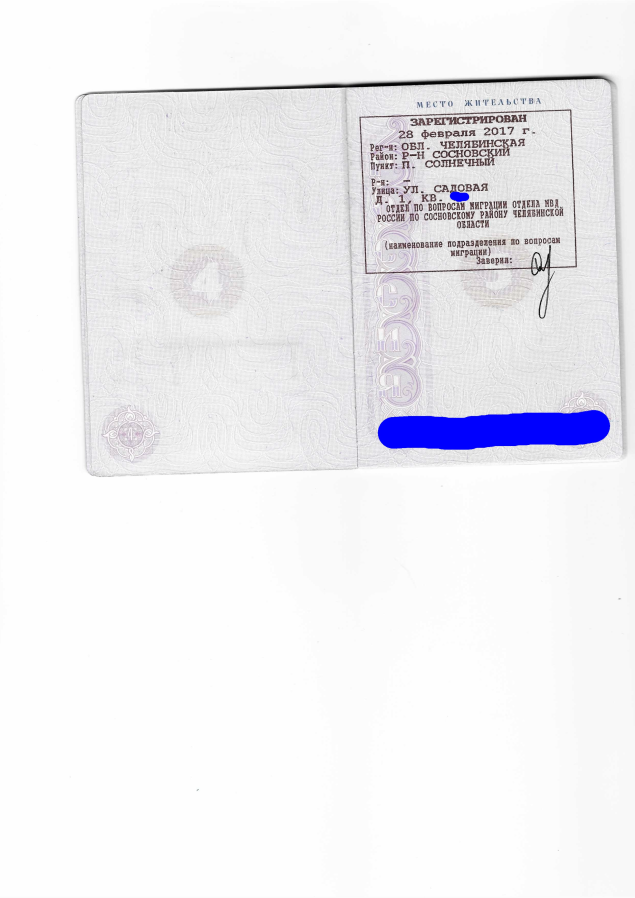

А вот результат работы программы

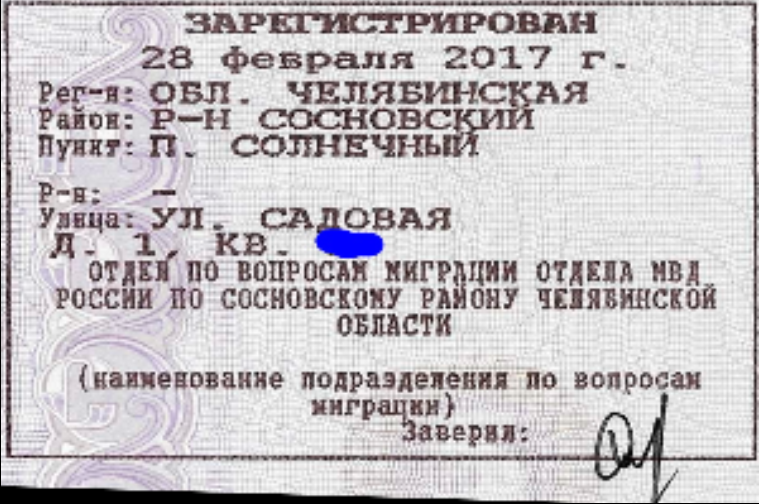

In [108]:
v_images_df

,width,height,id,file_name
0,2481,3507,0,85942.jpg
1,2456,3483,1,83393.jpg
2,1973,3508,2,83367.jpg
3,2631,3508,3,83283.jpg
4,2456,3483,4,83281.jpg
...,...,...,...,...
655,2631,3508,655,85972.jpg
656,1653,2338,656,85970.jpg
657,2551,3508,657,85968.jpg
658,2550,3507,658,85961.jpg


In [130]:
if os.path.exists('val_result'):
    shutil.rmtree('val_result')

os.mkdir("val_result")

for file_name in tqdm(v_images_df['file_name']):
    if os.path.exists(f"images/{file_name}"):
        img = cv2.imread(f"images/{file_name}")
        try:
            res_img = make_prediction(img)
            cv2.imwrite(f"val_result/{file_name}", res_img)
        except:
            print('По тем или иным причинам, модель не смогла обнаружить штамп')
    else:
        print("Изображение не найдено по указанному пути.")


  7%|████████████▉                                                                                                                                                                                 | 45/660 [00:08<01:09,  8.82it/s]

По тем или иным причинам, модель не смогла обнаружить штамп
По тем или иным причинам, модель не смогла обнаружить штамп


  8%|██████████████▋                                                                                                                                                                               | 51/660 [00:09<01:39,  6.11it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


  8%|███████████████▊                                                                                                                                                                              | 55/660 [00:10<01:31,  6.60it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 14%|██████████████████████████▊                                                                                                                                                                   | 93/660 [00:16<01:06,  8.52it/s]

По тем или иным причинам, модель не смогла обнаружить штамп
По тем или иным причинам, модель не смогла обнаружить штамп


 16%|██████████████████████████████▉                                                                                                                                                              | 108/660 [00:18<01:19,  6.94it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 18%|██████████████████████████████████▋                                                                                                                                                          | 121/660 [00:21<01:22,  6.53it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 20%|█████████████████████████████████████▊                                                                                                                                                       | 132/660 [00:24<02:34,  3.41it/s]

По тем или иным причинам, модель не смогла обнаружить штамп
По тем или иным причинам, модель не смогла обнаружить штамп


 25%|████████████████████████████████████████████████                                                                                                                                             | 168/660 [00:37<01:26,  5.71it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 26%|████████████████████████████████████████████████▋                                                                                                                                            | 170/660 [00:37<01:32,  5.28it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 28%|█████████████████████████████████████████████████████▊                                                                                                                                       | 188/660 [00:41<01:31,  5.18it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 29%|██████████████████████████████████████████████████████                                                                                                                                       | 189/660 [00:41<01:33,  5.06it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 29%|██████████████████████████████████████████████████████▋                                                                                                                                      | 191/660 [00:42<01:33,  5.01it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 29%|██████████████████████████████████████████████████████▉                                                                                                                                      | 192/660 [00:42<01:41,  4.61it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 30%|████████████████████████████████████████████████████████▍                                                                                                                                    | 197/660 [00:43<02:02,  3.77it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 37%|██████████████████████████████████████████████████████████████████████▍                                                                                                                      | 246/660 [00:54<01:23,  4.99it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 40%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 267/660 [01:00<01:19,  4.92it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 41%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 271/660 [01:00<01:11,  5.40it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 42%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 278/660 [01:03<01:59,  3.21it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 43%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 281/660 [01:03<01:29,  4.26it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 43%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 287/660 [01:06<02:42,  2.29it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 44%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 289/660 [01:06<01:57,  3.17it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 44%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 293/660 [01:07<01:17,  4.72it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 46%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 302/660 [01:09<01:16,  4.71it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 46%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 304/660 [01:09<01:18,  4.55it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 47%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 311/660 [01:11<01:07,  5.21it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 49%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 325/660 [01:14<01:12,  4.63it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 50%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 329/660 [01:15<01:07,  4.88it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 340/660 [01:17<01:16,  4.17it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 347/660 [01:21<02:32,  2.05it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 356/660 [01:23<00:55,  5.43it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 389/660 [01:30<00:51,  5.27it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 416/660 [01:38<01:01,  3.97it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 429/660 [01:40<00:38,  5.95it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 435/660 [01:41<00:41,  5.41it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 473/660 [01:47<00:22,  8.37it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 477/660 [01:47<00:18,  9.64it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 486/660 [01:48<00:19,  8.95it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 489/660 [01:49<00:17,  9.68it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 494/660 [01:50<00:27,  6.03it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 499/660 [01:51<00:30,  5.23it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 513/660 [01:53<00:18,  8.09it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 522/660 [01:54<00:22,  6.16it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 554/660 [02:00<00:16,  6.36it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 573/660 [02:03<00:13,  6.43it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 587/660 [02:05<00:14,  5.21it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 588/660 [02:06<00:13,  5.28it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 597/660 [02:07<00:13,  4.81it/s]

По тем или иным причинам, модель не смогла обнаружить штамп
По тем или иным причинам, модель не смогла обнаружить штамп


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 605/660 [02:09<00:08,  6.60it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 612/660 [02:09<00:04, 10.15it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 615/660 [02:10<00:05,  7.85it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 617/660 [02:10<00:06,  6.17it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 637/660 [02:15<00:04,  4.90it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 660/660 [02:19<00:00,  4.74it/s]


In [140]:
if os.path.exists('val_result_no_drag'):
    shutil.rmtree('val_result_no_drag')

os.mkdir("val_result_no_drag")

for file_name in tqdm(v_images_df['file_name']):
    if os.path.exists(f"images/{file_name}"):
        img = cv2.imread(f"images/{file_name}")
        try:
            res_img = fs_predict(img)
            cv2.imwrite(f"val_result_no_drag/{file_name}", res_img)
        except:
            print('По тем или иным причинам, модель не смогла обнаружить штамп')
    else:
        print("Изображение не найдено по указанному пути.")

  7%|████████████▉                                                                                                                                                                                 | 45/660 [00:08<01:12,  8.48it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


  8%|███████████████▎                                                                                                                                                                              | 53/660 [00:10<02:10,  4.66it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 17%|███████████████████████████████▏                                                                                                                                                             | 109/660 [00:19<01:22,  6.69it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 18%|██████████████████████████████████▋                                                                                                                                                          | 121/660 [00:21<01:15,  7.18it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 20%|██████████████████████████████████████                                                                                                                                                       | 133/660 [00:23<02:06,  4.16it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 29%|██████████████████████████████████████████████████████▉                                                                                                                                      | 192/660 [00:35<01:29,  5.26it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 41%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 271/660 [00:49<00:44,  8.73it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 43%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 282/660 [00:51<01:14,  5.08it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 47%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 310/660 [00:57<01:17,  4.54it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 50%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 329/660 [01:01<01:01,  5.37it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 341/660 [01:03<00:59,  5.35it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 355/660 [01:06<00:35,  8.70it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 389/660 [01:14<00:55,  4.91it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 428/660 [01:19<00:22, 10.28it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 473/660 [01:28<00:27,  6.90it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 477/660 [01:29<00:22,  8.12it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 486/660 [01:30<00:22,  7.65it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 489/660 [01:30<00:22,  7.73it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 511/660 [01:38<01:40,  1.48it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 585/660 [02:13<00:15,  4.83it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 598/660 [02:16<00:11,  5.55it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 604/660 [02:17<00:10,  5.10it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 612/660 [02:20<00:10,  4.74it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 615/660 [02:20<00:09,  4.71it/s]

По тем или иным причинам, модель не смогла обнаружить штамп


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 660/660 [02:33<00:00,  4.31it/s]


А теперь, что же не так?
1. Выше Вы видел два процесса сохранения, я хотел чтобы вы могли увидеть различия между работой программы, если коротко - вытяжения и масштабирование штампа работает плохо, а его нахождение хорошо.
2. Периодически процесс сохранения крашится, скорее всего, причина в изображениях или в том, что они повреждены, я несколько раз перекачивал с гугл диска картинки, потому что они портились, такая у меня догадка.
3. Навскидку, есть ещё одна проблема, иногда модель (yolov8) захватывает другие печати, но это происходит редко (оценивал на глаз)
4. Растяжение картинки это лёгкая задача, при условии что у нас есть идеальный прямоугольный контур, тут в дело вступают росписи или кляксы, или пятна, вообщем тут нужно ещё немного подумать, а сама технология растяжения картинки уже есть.
#### Спасибо за внимание!)